<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Untitled284.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

def make_grid(nx=256, ny=256, Lx=20.0, Ly=20.0):
    x = np.linspace(-Lx/2, Lx/2, nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, ny, endpoint=False)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y, indexing="xy")

    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")
    return x, y, X, Y, dx, dy, KX, KY

def normalize(psi, dx, dy):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return psi / (nrm + 1e-30)

def gaussian_packet(X, Y, x0=-4.0, y0=0.0, sx=1.2, sy=1.2, k0x=2.0, k0y=0.0):
    env = np.exp(-((X-x0)**2/(2*sx**2) + (Y-y0)**2/(2*sy**2)))
    phase = np.exp(1j*(k0x*X + k0y*Y))
    return env * phase

def add_vortex_phase(psi, X, Y, x_v=0.0, y_v=0.0, charge=1):
    theta = np.arctan2(Y - y_v, X - x_v)
    return psi * np.exp(1j * charge * theta)

def comb_ratchet_potential(X, Y, A=4.0, period=2.0, sharp=3.0, tilt=0.20, y_window=8.0):
    k = 2*np.pi/period
    tooth = np.sin(k*X) + 0.5*np.sin(2*k*X + np.pi/4)     # skewed profile
    tooth_sharp = np.tanh(sharp * tooth)                  # steep-but-smooth "teeth"
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))        # confine in y (a track)
    V = A * tooth_sharp * track + tilt * X                 # tilt sets directionality
    return V

def gate(t, duty=0.90, f=1.0, phase=0.0):
    T = 1.0 / f
    tau = (t + phase) % T
    return 1.0 if (tau < duty*T) else 0.0

def probability_current_x(psi, dx):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    return np.imag(np.conj(psi) * dpsi_dx)  # ħ=1, m=1

def run_tdse_gearing(
    nx=256, ny=256, Lx=22.0, Ly=22.0,
    dt=0.0015, nsteps=24000,
    A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0,
    gate_amp=1.2, duty=0.92, f=1.0,
    seed_vortex=True, vortex_charge=1,
    cut_x=0.0, report_every_cycles=1
):
    x, y, X, Y, dx, dy, KX, KY = make_grid(nx, ny, Lx, Ly)

    psi = gaussian_packet(X, Y, x0=-5.0, y0=0.0, sx=1.1, sy=1.1, k0x=2.0, k0y=0.0)
    if seed_vortex:
        psi = add_vortex_phase(psi, X, Y, x_v=-2.0, y_v=0.0, charge=vortex_charge)
    psi = normalize(psi, dx, dy)

    V0 = comb_ratchet_potential(X, Y, A=A, period=period, sharp=sharp, tilt=tilt, y_window=y_window)

    K2 = KX**2 + KY**2
    U_kin_half = np.exp(-0.5j * dt * (K2 / 2.0))  # exp(-i dt (k^2)/2) split into halves

    cut_idx = int(np.argmin(np.abs(x - cut_x)))
    T = 1.0 / f
    steps_per_cycle = max(1, int(round(T / dt)))
    report_every_steps = report_every_cycles * steps_per_cycle

    net_flux = 0.0
    t = 0.0

    for step in range(1, nsteps + 1):
        g = gate(t, duty=duty, f=f)
        Vt = V0 + gate_amp * g * V0

        psi *= np.exp(-0.5j * dt * Vt)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi *= np.exp(-0.5j * dt * Vt)

        if step % 200 == 0:
            psi = normalize(psi, dx, dy)

        Jx = probability_current_x(psi, dx)
        flux_cut = np.sum(Jx[:, cut_idx]) * dy
        net_flux += flux_cut * dt

        if step % report_every_steps == 0:
            cycles = step / steps_per_cycle
            print(f"t={t:8.4f}  cycles={cycles:7.2f}  gate={g:.0f}  net_flux≈{net_flux:+.6e}")

        t += dt

    return {"x": x, "y": y, "psi": psi, "V0": V0, "net_flux": net_flux, "dx": dx, "dy": dy}

if __name__ == "__main__":
    out = run_tdse_gearing()
    print("Done. net_flux:", out["net_flux"])

t=  0.9990  cycles=   1.00  gate=0  net_flux≈+4.012289e-02
t=  1.9995  cycles=   2.00  gate=0  net_flux≈+1.055930e-01
t=  3.0000  cycles=   3.00  gate=1  net_flux≈+9.371537e-02
t=  4.0005  cycles=   4.00  gate=1  net_flux≈+8.635282e-02
t=  5.0010  cycles=   5.00  gate=1  net_flux≈+8.307473e-02
t=  6.0015  cycles=   6.00  gate=1  net_flux≈+9.687403e-02
t=  7.0020  cycles=   7.00  gate=1  net_flux≈+1.119161e-01
t=  8.0025  cycles=   8.00  gate=1  net_flux≈+8.627914e-02
t=  9.0030  cycles=   9.00  gate=1  net_flux≈+6.031666e-02
t= 10.0035  cycles=  10.00  gate=1  net_flux≈+6.028623e-02
t= 11.0040  cycles=  11.00  gate=1  net_flux≈+3.630974e-02
t= 12.0045  cycles=  12.00  gate=1  net_flux≈+4.414532e-02
t= 13.0050  cycles=  13.00  gate=1  net_flux≈+1.817009e-02
t= 14.0055  cycles=  14.00  gate=1  net_flux≈-6.879355e-03
t= 15.0060  cycles=  15.00  gate=1  net_flux≈-1.047427e-02
t= 16.0065  cycles=  16.00  gate=1  net_flux≈-1.147679e-02
t= 17.0070  cycles=  17.00  gate=1  net_flux≈-1.337052e-

In [ ]:
import numpy as np
import csv

def make_grid(nx=256, ny=256, Lx=20.0, Ly=20.0):
    x = np.linspace(-Lx/2, Lx/2, nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, ny, endpoint=False)
    dx = x[1] - x[0]
    dy = y[1] - y[0]
    X, Y = np.meshgrid(x, y, indexing="xy")

    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")
    return x, y, X, Y, dx, dy, KX, KY

def normalize(psi, dx, dy):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return psi / (nrm + 1e-30)

def gaussian_packet(X, Y, x0=-4.0, y0=0.0, sx=1.2, sy=1.2, k0x=2.0, k0y=0.0):
    env = np.exp(-((X-x0)**2/(2*sx**2) + (Y-y0)**2/(2*sy**2)))
    phase = np.exp(1j*(k0x*X + k0y*Y))
    return env * phase

def add_vortex_phase(psi, X, Y, x_v=0.0, y_v=0.0, charge=1):
    theta = np.arctan2(Y - y_v, X - x_v)
    return psi * np.exp(1j * charge * theta)

def comb_ratchet_potential(X, Y, A=4.0, period=2.0, sharp=3.0, tilt=0.20, y_window=8.0):
    k = 2*np.pi/period
    tooth = np.sin(k*X) + 0.5*np.sin(2*k*X + np.pi/4)
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track + tilt * X

def gate(t, duty=0.90, f=1.0, phase=0.0):
    T = 1.0 / f
    return 1.0 if ((t + phase) % T) < duty*T else 0.0

def probability_current_x(psi, dx):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    return np.imag(np.conj(psi) * dpsi_dx)

def run_tdse_gearing(
    nx=256, ny=256, Lx=22.0, Ly=22.0,
    dt=0.0015, nsteps=24000,
    A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0,
    gate_amp=1.2, duty=0.92, f=1.0,
    seed_vortex=True, vortex_charge=1,
    cut_x=0.0,
    csv_file="gearing_flux.csv",
    npz_file="gearing_output.npz"
):
    x, y, X, Y, dx, dy, KX, KY = make_grid(nx, ny, Lx, Ly)

    psi = gaussian_packet(X, Y, x0=-5.0, y0=0.0, sx=1.1, sy=1.1, k0x=2.0)
    if seed_vortex:
        psi = add_vortex_phase(psi, X, Y, x_v=-2.0, charge=vortex_charge)
    psi = normalize(psi, dx, dy)

    V0 = comb_ratchet_potential(X, Y, A=A, period=period,
                                sharp=sharp, tilt=tilt, y_window=y_window)

    K2 = KX**2 + KY**2
    U_kin_half = np.exp(-0.5j * dt * (K2 / 2.0))

    cut_idx = int(np.argmin(np.abs(x - cut_x)))
    T = 1.0 / f
    steps_per_cycle = max(1, int(round(T / dt)))

    records = []
    net_flux = 0.0
    cycle_flux = 0.0
    t = 0.0
    cycle = 0

    for step in range(1, nsteps + 1):
        g = gate(t, duty=duty, f=f)
        Vt = V0 + gate_amp * g * V0

        psi *= np.exp(-0.5j * dt * Vt)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi *= np.exp(-0.5j * dt * Vt)

        if step % 200 == 0:
            psi = normalize(psi, dx, dy)

        Jx = probability_current_x(psi, dx)
        flux_cut = np.sum(Jx[:, cut_idx]) * dy
        net_flux += flux_cut * dt
        cycle_flux += flux_cut * dt

        if step % steps_per_cycle == 0:
            cycle += 1
            records.append([cycle, t, g, cycle_flux, net_flux])
            print(f"cycle={cycle:3d}  gate={g:.0f}  "
                  f"cycle_flux={cycle_flux:+.3e}  net_flux={net_flux:+.3e}")
            cycle_flux = 0.0

        t += dt

    # Save CSV
    with open(csv_file, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["cycle", "time", "gate", "cycle_flux", "net_flux"])
        writer.writerows(records)

    # Save NPZ (rich state)
    np.savez(
        npz_file,
        x=x, y=y,
        psi=psi,
        V0=V0,
        records=np.array(records),
        params=dict(
            dt=dt, nsteps=nsteps, duty=duty, f=f,
            A=A, period=period, sharp=sharp, tilt=tilt
        )
    )

    return records

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# === Colab-safe TDSE "quantum gearing" run + save + quick plot ===

import numpy as np
import os, csv
import matplotlib.pyplot as plt

# ---- force output directory (Colab-visible) ----
OUTDIR = "/content/gearing_outputs"
os.makedirs(OUTDIR, exist_ok=True)
csv_file = os.path.join(OUTDIR, "gearing_flux.csv")
npz_file = os.path.join(OUTDIR, "gearing_output.npz")

print("Saving to:", OUTDIR)

# ---- utilities ----
def make_grid(nx=256, ny=256, Lx=22.0, Ly=22.0):
    x = np.linspace(-Lx/2, Lx/2, nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, ny, endpoint=False)
    dx, dy = x[1]-x[0], y[1]-y[0]
    X, Y = np.meshgrid(x, y, indexing="xy")
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")
    return x, y, X, Y, dx, dy, KX, KY

def normalize(psi, dx, dy):
    return psi / (np.sqrt(np.sum(np.abs(psi)**2)*dx*dy) + 1e-30)

def gaussian_packet(X, Y, x0=-5.0, sx=1.1, sy=1.1, k0x=2.0):
    return np.exp(-((X-x0)**2/(2*sx**2) + Y**2/(2*sy**2))) * np.exp(1j*k0x*X)

def add_vortex_phase(psi, X, Y, x_v=-2.0, charge=1):
    return psi * np.exp(1j*charge*np.arctan2(Y, X-x_v))

def comb_ratchet_potential(X, Y, A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.sin(k*X) + 0.5*np.sin(2*k*X + np.pi/4)
    tooth = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A*tooth*track + tilt*X

def gate(t, duty=0.92, f=1.0):
    T = 1.0/f
    return 1.0 if (t % T) < duty*T else 0.0

def probability_current_x(psi, dx):
    dpsi_dx = (np.roll(psi,-1,axis=1)-np.roll(psi,1,axis=1))/(2*dx)
    return np.imag(np.conj(psi)*dpsi_dx)

# ---- parameters ----
dt = 0.0015
nsteps = 24000



f = 1.0
duty = 0.92

# ---- grid & initial state ----
x, y, X, Y, dx, dy, KX, KY = make_grid()
psi = gaussian_packet(X, Y)
psi = add_vortex_phase(psi, X, Y)
psi = normalize(psi, dx, dy)

V0 = comb_ratchet_potential(X, Y)

K2 = KX**2 + KY**2
U_kin_half = np.exp(-0.5j * dt * (K2/2.0))

cut_idx = np.argmin(np.abs(x - 0.0))
steps_per_cycle = int(round((1.0/f)/dt))

records = []
net_flux = 0.0
cycle_flux = 0.0
t = 0.0
cycle = 0

print("TDSE run started...")

# ---- main loop ----
for step in range(1, nsteps+1):
    g = gate(t, duty=duty, f=f)
    Vt = V0 + 1.2*g*V0

    psi *= np.exp(-0.5j*dt*Vt)

    psi_k = np.fft.fft2(psi)
    psi_k *= U_kin_half
    psi = np.fft.ifft2(psi_k)

    psi_k = np.fft.fft2(psi)
    psi_k *= U_kin_half
    psi = np.fft.ifft2(psi_k)

    psi *= np.exp(-0.5j*dt*Vt)

    if step % 200 == 0:
        psi = normalize(psi, dx, dy)

    Jx = probability_current_x(psi, dx)
    flux = np.sum(Jx[:, cut_idx]) * dy * dt
    net_flux += flux
    cycle_flux += flux

    if step % steps_per_cycle == 0:
        cycle += 1
        records.append([cycle, t, g, cycle_flux, net_flux])
        print(f"cycle={cycle:3d}  gate={int(g)}  "
              f"cycle_flux={cycle_flux:+.3e}  net_flux={net_flux:+.3e}")
        cycle_flux = 0.0

    t += dt

# ---- save outputs ----
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["cycle","time","gate","cycle_flux","net_flux"])
    writer.writerows(records)

np.savez(
    npz_file,
    x=x, y=y,
    psi=psi,
    V0=V0,
    records=np.array(records),
    params=dict(dt=dt, nsteps=nsteps, duty=duty, f=f)
)

print("Saved files:")
print(os.listdir(OUTDIR))

# ---- quick plot ----
records = np.array(records)
plt.figure()
plt.plot(records[:,0], records[:,3], label="cycle_flux")
plt.plot(records[:,0], records[:,4], label="net_flux")
plt.axhline(0, lw=0.5)
plt.xlabel("cycle")
plt.ylabel("flux")
plt.legend()
plt.show()

Saving to: /content/gearing_outputs
TDSE run started...
cycle=  1  gate=0  cycle_flux=+4.012e-02  net_flux=+4.012e-02
cycle=  2  gate=0  cycle_flux=+6.547e-02  net_flux=+1.056e-01
cycle=  3  gate=1  cycle_flux=-1.188e-02  net_flux=+9.372e-02
cycle=  4  gate=1  cycle_flux=-7.363e-03  net_flux=+8.635e-02
cycle=  5  gate=1  cycle_flux=-3.278e-03  net_flux=+8.307e-02
cycle=  6  gate=1  cycle_flux=+1.380e-02  net_flux=+9.687e-02
cycle=  7  gate=1  cycle_flux=+1.504e-02  net_flux=+1.119e-01
cycle=  8  gate=1  cycle_flux=-2.564e-02  net_flux=+8.628e-02
cycle=  9  gate=1  cycle_flux=-2.596e-02  net_flux=+6.032e-02
cycle= 10  gate=1  cycle_flux=-3.043e-05  net_flux=+6.029e-02
cycle= 11  gate=1  cycle_flux=-2.398e-02  net_flux=+3.631e-02
cycle= 12  gate=1  cycle_flux=+7.836e-03  net_flux=+4.415e-02
cycle= 13  gate=1  cycle_flux=-2.598e-02  net_flux=+1.817e-02
cycle= 14  gate=1  cycle_flux=-2.505e-02  net_flux=-6.879e-03
cycle= 15  gate=1  cycle_flux=-3.595e-03  net_flux=-1.047e-02
cycle= 16  gat

TypeError: cannot pickle 'TextIOWrapper' instances

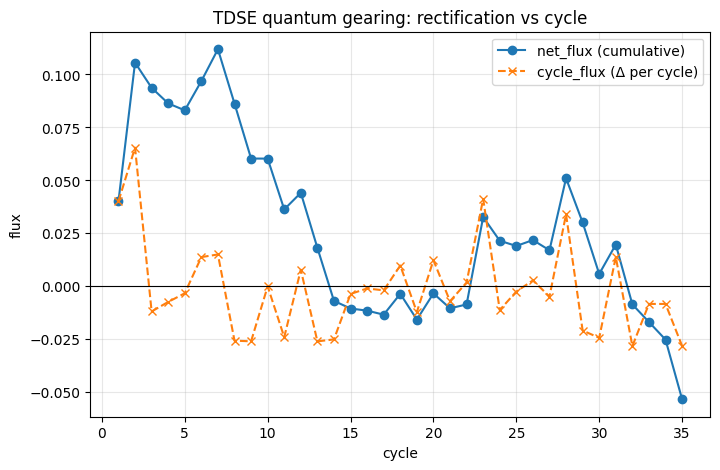

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ---- pasted data (cycle, net_flux) from your output ----
data = np.array([
    [1,  4.012289e-02],
    [2,  1.055930e-01],
    [3,  9.371537e-02],
    [4,  8.635282e-02],
    [5,  8.307473e-02],
    [6,  9.687403e-02],
    [7,  1.119161e-01],
    [8,  8.627914e-02],
    [9,  6.031666e-02],
    [10, 6.028623e-02],
    [11, 3.630974e-02],
    [12, 4.414532e-02],
    [13, 1.817009e-02],
    [14,-6.879355e-03],
    [15,-1.047427e-02],
    [16,-1.147679e-02],
    [17,-1.337052e-02],
    [18,-3.538550e-03],
    [19,-1.568832e-02],
    [20,-3.340887e-03],
    [21,-1.036589e-02],
    [22,-8.556480e-03],
    [23, 3.270900e-02],
    [24, 2.152087e-02],
    [25, 1.904925e-02],
    [26, 2.184195e-02],
    [27, 1.702897e-02],
    [28, 5.100794e-02],
    [29, 3.015218e-02],
    [30, 5.840401e-03],
    [31, 1.971004e-02],
    [32,-8.530771e-03],
    [33,-1.683846e-02],
    [34,-2.514799e-02],
    [35,-5.328529e-02],
])

cycles = data[:,0]
net_flux = data[:,1]

# per-cycle increment (discrete derivative)
cycle_flux = np.diff(net_flux, prepend=0.0)

# ---- plotting ----
plt.figure(figsize=(8,5))

plt.plot(cycles, net_flux, marker="o", label="net_flux (cumulative)")
plt.plot(cycles, cycle_flux, marker="x", linestyle="--", label="cycle_flux (Δ per cycle)")

plt.axhline(0, color="k", lw=0.8)
plt.xlabel("cycle")
plt.ylabel("flux")
plt.title("TDSE quantum gearing: rectification vs cycle")
plt.legend()
plt.grid(alpha=0.3)

plt.show()

In [ ]:
import os, json, time, math
import numpy as np

# =========================
# Colab output destinations
# =========================
OUT_CONTENT = "/content/gqr_gearing_runs"
os.makedirs(OUT_CONTENT, exist_ok=True)

USE_DRIVE = True  # set False if you don't want Drive mirroring
OUT_DRIVE = "/content/drive/MyDrive/gqr_gearing_runs"

if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    os.makedirs(OUT_DRIVE, exist_ok=True)

def _now_tag():
    return time.strftime("%Y%m%d_%H%M%S")

# =========================
# Grid + physics utilities
# =========================
def make_grid(nx, ny, Lx, Ly):
    x = np.linspace(-Lx/2, Lx/2, nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, ny, endpoint=False)
    dx, dy = x[1]-x[0], y[1]-y[0]
    X, Y = np.meshgrid(x, y, indexing="xy")
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")
    return x, y, X, Y, dx, dy, KX, KY

def normalize(psi, dx, dy):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return psi / (nrm + 1e-30)

def gaussian_packet(X, Y, x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0):
    env = np.exp(-((X-x0)**2/(2*sx**2) + (Y-y0)**2/(2*sy**2)))
    phase = np.exp(1j*(k0x*X + k0y*Y))
    return env * phase

def phase_vortex(X, Y, x_v=0.0, y_v=0.0, charge=1):
    theta = np.arctan2(Y - y_v, X - x_v)
    return np.exp(1j * charge * theta)

def add_single_vortex(psi, X, Y, x_v=0.0, y_v=0.0, charge=1):
    return psi * phase_vortex(X, Y, x_v=x_v, y_v=y_v, charge=charge)

def add_vortex_pair(psi, X, Y, x0=2.0, y0=0.0, charge=1):
    # net topological charge 0
    return psi * phase_vortex(X, Y, x_v=+x0, y_v=y0, charge=+charge) * phase_vortex(X, Y, x_v=-x0, y_v=y0, charge=-charge)

def px_mean(psi, dx, dy):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    Jx = np.imag(np.conj(psi) * dpsi_dx)  # ħ=1
    return float(np.sum(Jx) * dx * dy)

def x_mean(psi, X, dx, dy):
    rho = np.abs(psi)**2
    return float(np.sum(rho * X) * dx * dy)

def flux_cut_x(psi, dx, dy, cut_idx):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    Jx = np.imag(np.conj(psi) * dpsi_dx)
    return float(np.sum(Jx[:, cut_idx]) * dy)

# =========================
# Potentials (teeth)
# =========================
def V_even_cos(X, Y, A=4.0, period=2.2, sharp=3.5, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.cos(k*X)                           # parity-even
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track

def V_skew_tilt(X, Y, A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.sin(k*X) + 0.5*np.sin(2*k*X + np.pi/4)  # skewed
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track + tilt * X

# =========================
# Gate waveforms
# =========================
def gate_square(t, duty=0.92, f_hz=1.0):
    T = 1.0 / f_hz
    return 1.0 if (t % T) < duty*T else 0.0

def gate_sine(t, f_hz=1.0):
    return 0.5 * (1.0 + np.sin(2*np.pi*f_hz*t))

def gate_raised_cosine_pulse(t, duty=0.92, f_hz=1.0):
    T = 1.0 / f_hz
    tau = t % T
    on = duty * T
    if tau >= on:
        return 0.0
    u = tau / on
    return np.sin(np.pi * u)**2

GATES = {
    "square": gate_square,
    "sine": gate_sine,
    "rcos": gate_raised_cosine_pulse,
}

POTS = {
    "even_cos": V_even_cos,
    "skew_tilt": V_skew_tilt,
}

# =========================
# Core TDSE runner
# =========================
def run_tdse_case(cfg):
    nx = cfg["nx"]; ny = cfg["ny"]
    Lx = cfg["Lx"]; Ly = cfg["Ly"]
    dt = cfg["dt"]
    cycles = cfg["cycles"]
    f_hz = cfg["f_hz"]
    duty = cfg.get("duty", 0.92)
    gate_amp = cfg.get("gate_amp", 1.2)

    pot_name = cfg["potential"]["name"]
    pot_kwargs = cfg["potential"].get("kwargs", {})
    gate_name = cfg["gate"]["name"]
    gate_kwargs = cfg["gate"].get("kwargs", {})

    init = cfg["init"]
    meas = cfg.get("measure", {"cut_x": 0.0, "save_psi": True, "save_V0": True})

    x, y, X, Y, dx, dy, KX, KY = make_grid(nx, ny, Lx, Ly)

    psi = gaussian_packet(
        X, Y,
        x0=init.get("x0", 0.0), y0=init.get("y0", 0.0),
        sx=init.get("sx", 1.2), sy=init.get("sy", 1.2),
        k0x=init.get("k0x", 0.0), k0y=init.get("k0y", 0.0)
    )

    topo = init.get("topology", "none")
    if topo == "single_vortex":
        psi = add_single_vortex(psi, X, Y, x_v=init.get("xv", 0.0), y_v=init.get("yv", 0.0), charge=init.get("charge", 1))
    elif topo == "vortex_pair":
        psi = add_vortex_pair(psi, X, Y, x0=init.get("pair_x0", 2.0), y0=init.get("pair_y0", 0.0), charge=init.get("charge", 1))

    psi = normalize(psi, dx, dy)

    V0 = POTS[pot_name](X, Y, **pot_kwargs)
    gate_fun = GATES[gate_name]

    # Kinetic half-step operator
    K2 = KX**2 + KY**2
    U_kin_half = np.exp(-0.5j * dt * (K2 / 2.0))  # ħ=1, m=1

    steps_per_cycle = int(round((1.0 / f_hz) / dt))
    nsteps = cycles * steps_per_cycle

    cut_x = meas.get("cut_x", 0.0)
    cut_idx = int(np.argmin(np.abs(x - cut_x)))

    records = []
    t = 0.0

    for step in range(1, nsteps + 1):
        g = float(gate_fun(t, duty=duty, f_hz=f_hz, **gate_kwargs)) if gate_name != "sine" else float(gate_fun(t, f_hz=f_hz, **gate_kwargs))
        Vt = V0 + gate_amp * g * V0

        # V half
        psi *= np.exp(-0.5j * dt * Vt)

        # K full via FFT (two half steps)
        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        # V half
        psi *= np.exp(-0.5j * dt * Vt)

        if step % 200 == 0:
            psi = normalize(psi, dx, dy)

        if step % steps_per_cycle == 0:
            cyc = step // steps_per_cycle
            records.append({
                "cycle": int(cyc),
                "time": float(t),
                "gate": float(g),
                "px_mean": px_mean(psi, dx, dy),
                "x_mean": x_mean(psi, X, dx, dy),
                "flux_cut": flux_cut_x(psi, dx, dy, cut_idx),
            })
        t += dt

    out = {
        "cfg": cfg,
        "records": records,
    }
    if meas.get("save_psi", True):
        out["psi"] = psi
    if meas.get("save_V0", True):
        out["V0"] = V0
    out["x"] = x
    out["y"] = y
    return out

def save_npz(out, name_base, tag=None):
    tag = tag or _now_tag()
    fname = f"{name_base}_{tag}.npz"
    path_content = os.path.join(OUT_CONTENT, fname)

    rec = out["records"]
    # store records as a structured array for easy loading
    rec_arr = np.array([(r["cycle"], r["time"], r["gate"], r["px_mean"], r["x_mean"], r["flux_cut"]) for r in rec],
                       dtype=[("cycle","i4"),("time","f8"),("gate","f8"),("px_mean","f8"),("x_mean","f8"),("flux_cut","f8")])

    np.savez(
        path_content,
        cfg_json=json.dumps(out["cfg"]),
        records=rec_arr,
        x=out["x"], y=out["y"],
        psi=out.get("psi", None),
        V0=out.get("V0", None),
    )

    path_drive = None
    if USE_DRIVE:
        path_drive = os.path.join(OUT_DRIVE, fname)
        # mirror
        with open(path_content, "rb") as fsrc, open(path_drive, "wb") as fdst:
            fdst.write(fsrc.read())

    return path_content, path_drive

# =========================
# Frozen run list (main + SI)
# =========================
BASE = dict(
    nx=128, ny=128,
    Lx=22.0, Ly=22.0,
    dt=0.0015,
    cycles=20,             # raise later (e.g. 60–200) once pipeline is stable
    f_hz=1.0,
    duty=0.92,
    gate_amp=1.2,
    measure=dict(cut_x=0.0, save_psi=True, save_V0=True),
)

RUNS = []

# Fig 2: Effect (square gate)
RUNS.append(dict(
    **BASE,
    name="fig2_effect_square",
    potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
))

# Fig 3: Null (square gate)
RUNS.append(dict(
    **BASE,
    name="fig3_null_square",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
))

# Fig 5a: waveform dependence (effect)
for gname in ["square","sine","rcos"]:
    RUNS.append(dict(
        **BASE,
        name=f"fig5a_effect_{gname}",
        potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
        gate=dict(name=gname, kwargs={}),
        init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
    ))

# Fig 5b: waveform null control
for gname in ["square","sine","rcos"]:
    RUNS.append(dict(
        **BASE,
        name=f"fig5b_null_{gname}",
        potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
        gate=dict(name=gname, kwargs={}),
        init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
    ))

# SI S1: strict topology control (null): none vs single vortex vs vortex pair
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_none",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="none"),
))
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_single",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="single_vortex", charge=1, xv=0.0, yv=0.0),
))
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_pair",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="vortex_pair", charge=1, pair_x0=2.0, pair_y0=0.0),
))

# SI S2: dt sensitivity (effect + null) baseline vs half-step
for dt in [0.0015, 0.00075]:
    RUNS.append(dict(
        **{**BASE, "dt": dt, "cycles": 10},
        name=f"S2_null_dt_{dt}",
        potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
        gate=dict(name="square", kwargs={}),
        init=dict(topology="none"),
    ))
    RUNS.append(dict(
        **{**BASE, "dt": dt, "cycles": 10},
        name=f"S2_effect_dt_{dt}",
        potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
        gate=dict(name="square", kwargs={}),
        init=dict(topology="none"),
    ))

# =========================
# Execute batch
# =========================
tag = _now_tag()
saved = []

print(f"Running {len(RUNS)} cases. Tag={tag}")
for i, cfg in enumerate(RUNS, 1):
    name = cfg["name"]
    print(f"[{i:02d}/{len(RUNS):02d}] {name} ...")
    out = run_tdse_case(cfg)
    p_content, p_drive = save_npz(out, name_base=name, tag=tag)
    saved.append((name, p_content, p_drive))
    print("  saved:", p_content, ("| mirrored" if p_drive else ""))

print("\nDONE. Saved files (first 5 shown):")
for row in saved[:5]:
    print(row)
print(f"... total saved: {len(saved)}")
print("Content dir:", OUT_CONTENT)
if USE_DRIVE:
    print("Drive dir:", OUT_DRIVE)

In [ ]:
import os, json, time, math
import numpy as np

# =========================
# Colab output destinations
# =========================
OUT_CONTENT = "/content/gqr_gearing_runs"
os.makedirs(OUT_CONTENT, exist_ok=True)

USE_DRIVE = True  # set False if you don't want Drive mirroring
OUT_DRIVE = "/content/drive/MyDrive/gqr_gearing_runs"

if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    os.makedirs(OUT_DRIVE, exist_ok=True)

def _now_tag():
    return time.strftime("%Y%m%d_%H%M%S")

# =========================
# Grid + physics utilities
# =========================
def make_grid(nx, ny, Lx, Ly):
    x = np.linspace(-Lx/2, Lx/2, nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, ny, endpoint=False)
    dx, dy = x[1]-x[0], y[1]-y[0]
    X, Y = np.meshgrid(x, y, indexing="xy")
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")
    return x, y, X, Y, dx, dy, KX, KY

def normalize(psi, dx, dy):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return psi / (nrm + 1e-30)

def gaussian_packet(X, Y, x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0):
    env = np.exp(-((X-x0)**2/(2*sx**2) + (Y-y0)**2/(2*sy**2)))
    phase = np.exp(1j*(k0x*X + k0y*Y))
    return env * phase

def phase_vortex(X, Y, x_v=0.0, y_v=0.0, charge=1):
    theta = np.arctan2(Y - y_v, X - x_v)
    return np.exp(1j * charge * theta)

def add_single_vortex(psi, X, Y, x_v=0.0, y_v=0.0, charge=1):
    return psi * phase_vortex(X, Y, x_v=x_v, y_v=y_v, charge=charge)

def add_vortex_pair(psi, X, Y, x0=2.0, y0=0.0, charge=1):
    # net topological charge 0
    return psi * phase_vortex(X, Y, x_v=+x0, y_v=y0, charge=+charge) * phase_vortex(X, Y, x_v=-x0, y_v=y0, charge=-charge)

def px_mean(psi, dx, dy):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    Jx = np.imag(np.conj(psi) * dpsi_dx)  # ħ=1
    return float(np.sum(Jx) * dx * dy)

def x_mean(psi, X, dx, dy):
    rho = np.abs(psi)**2
    return float(np.sum(rho * X) * dx * dy)

def flux_cut_x(psi, dx, dy, cut_idx):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    Jx = np.imag(np.conj(psi) * dpsi_dx)
    return float(np.sum(Jx[:, cut_idx]) * dy)

# =========================
# Potentials (teeth)
# =========================
def V_even_cos(X, Y, A=4.0, period=2.2, sharp=3.5, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.cos(k*X)                           # parity-even
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track

def V_skew_tilt(X, Y, A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.sin(k*X) + 0.5*np.sin(2*k*X + np.pi/4)  # skewed
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track + tilt * X

# =========================
# Gate waveforms
# =========================
def gate_square(t, duty=0.92, f_hz=1.0):
    T = 1.0 / f_hz
    return 1.0 if (t % T) < duty*T else 0.0

def gate_sine(t, f_hz=1.0):
    return 0.5 * (1.0 + np.sin(2*np.pi*f_hz*t))

def gate_raised_cosine_pulse(t, duty=0.92, f_hz=1.0):
    T = 1.0 / f_hz
    tau = t % T
    on = duty * T
    if tau >= on:
        return 0.0
    u = tau / on
    return np.sin(np.pi * u)**2

GATES = {
    "square": gate_square,
    "sine": gate_sine,
    "rcos": gate_raised_cosine_pulse,
}

POTS = {
    "even_cos": V_even_cos,
    "skew_tilt": V_skew_tilt,
}

# =========================
# Core TDSE runner
# =========================
def run_tdse_case(cfg):
    nx = cfg["nx"]; ny = cfg["ny"]
    Lx = cfg["Lx"]; Ly = cfg["Ly"]
    dt = cfg["dt"]
    cycles = cfg["cycles"]
    f_hz = cfg["f_hz"]
    duty = cfg.get("duty", 0.92)
    gate_amp = cfg.get("gate_amp", 1.2)

    pot_name = cfg["potential"]["name"]
    pot_kwargs = cfg["potential"].get("kwargs", {})
    gate_name = cfg["gate"]["name"]
    gate_kwargs = cfg["gate"].get("kwargs", {})

    init = cfg["init"]
    meas = cfg.get("measure", {"cut_x": 0.0, "save_psi": True, "save_V0": True})

    x, y, X, Y, dx, dy, KX, KY = make_grid(nx, ny, Lx, Ly)

    psi = gaussian_packet(
        X, Y,
        x0=init.get("x0", 0.0), y0=init.get("y0", 0.0),
        sx=init.get("sx", 1.2), sy=init.get("sy", 1.2),
        k0x=init.get("k0x", 0.0), k0y=init.get("k0y", 0.0)
    )

    topo = init.get("topology", "none")
    if topo == "single_vortex":
        psi = add_single_vortex(psi, X, Y, x_v=init.get("xv", 0.0), y_v=init.get("yv", 0.0), charge=init.get("charge", 1))
    elif topo == "vortex_pair":
        psi = add_vortex_pair(psi, X, Y, x0=init.get("pair_x0", 2.0), y0=init.get("pair_y0", 0.0), charge=init.get("charge", 1))

    psi = normalize(psi, dx, dy)

    V0 = POTS[pot_name](X, Y, **pot_kwargs)
    gate_fun = GATES[gate_name]

    # Kinetic half-step operator
    K2 = KX**2 + KY**2
    U_kin_half = np.exp(-0.5j * dt * (K2 / 2.0))  # ħ=1, m=1

    steps_per_cycle = int(round((1.0 / f_hz) / dt))
    nsteps = cycles * steps_per_cycle

    cut_x = meas.get("cut_x", 0.0)
    cut_idx = int(np.argmin(np.abs(x - cut_x)))

    records = []
    t = 0.0

    for step in range(1, nsteps + 1):
        g = float(gate_fun(t, duty=duty, f_hz=f_hz, **gate_kwargs)) if gate_name != "sine" else float(gate_fun(t, f_hz=f_hz, **gate_kwargs))
        Vt = V0 + gate_amp * g * V0

        # V half
        psi *= np.exp(-0.5j * dt * Vt)

        # K full via FFT (two half steps)
        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        # V half
        psi *= np.exp(-0.5j * dt * Vt)

        if step % 200 == 0:
            psi = normalize(psi, dx, dy)

        if step % steps_per_cycle == 0:
            cyc = step // steps_per_cycle
            records.append({
                "cycle": int(cyc),
                "time": float(t),
                "gate": float(g),
                "px_mean": px_mean(psi, dx, dy),
                "x_mean": x_mean(psi, X, dx, dy),
                "flux_cut": flux_cut_x(psi, dx, dy, cut_idx),
            })
        t += dt

    out = {
        "cfg": cfg,
        "records": records,
    }
    if meas.get("save_psi", True):
        out["psi"] = psi
    if meas.get("save_V0", True):
        out["V0"] = V0
    out["x"] = x
    out["y"] = y
    return out

def save_npz(out, name_base, tag=None):
    tag = tag or _now_tag()
    fname = f"{name_base}_{tag}.npz"
    path_content = os.path.join(OUT_CONTENT, fname)

    rec = out["records"]
    # store records as a structured array for easy loading
    rec_arr = np.array([(r["cycle"], r["time"], r["gate"], r["px_mean"], r["x_mean"], r["flux_cut"]) for r in rec],
                       dtype=[("cycle","i4"),("time","f8"),("gate","f8"),("px_mean","f8"),("x_mean","f8"),("flux_cut","f8")])

    np.savez(
        path_content,
        cfg_json=json.dumps(out["cfg"]),
        records=rec_arr,
        x=out["x"], y=out["y"],
        psi=out.get("psi", None),
        V0=out.get("V0", None),
    )

    path_drive = None
    if USE_DRIVE:
        path_drive = os.path.join(OUT_DRIVE, fname)
        # mirror
        with open(path_content, "rb") as fsrc, open(path_drive, "wb") as fdst:
            fdst.write(fsrc.read())

    return path_content, path_drive

# =========================
# Frozen run list (main + SI)
# =========================
BASE = dict(
    nx=128, ny=128,
    Lx=22.0, Ly=22.0,
    dt=0.0015,
    cycles=20,             # raise later (e.g. 60–200) once pipeline is stable
    f_hz=1.0,
    duty=0.92,
    gate_amp=1.2,
    measure=dict(cut_x=0.0, save_psi=True, save_V0=True),
)

RUNS = []

# Fig 2: Effect (square gate)
RUNS.append(dict(
    **BASE,
    name="fig2_effect_square",
    potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
))

# Fig 3: Null (square gate)
RUNS.append(dict(
    **BASE,
    name="fig3_null_square",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
))

# Fig 5a: waveform dependence (effect)
for gname in ["square","sine","rcos"]:
    RUNS.append(dict(
        **BASE,
        name=f"fig5a_effect_{gname}",
        potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
        gate=dict(name=gname, kwargs={}),
        init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
    ))

# Fig 5b: waveform null control
for gname in ["square","sine","rcos"]:
    RUNS.append(dict(
        **BASE,
        name=f"fig5b_null_{gname}",
        potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
        gate=dict(name=gname, kwargs={}),
        init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
    ))

# SI S1: strict topology control (null): none vs single vortex vs vortex pair
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_none",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="none"),
))
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_single",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="single_vortex", charge=1, xv=0.0, yv=0.0),
))
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_pair",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="vortex_pair", charge=1, pair_x0=2.0, pair_y0=0.0),
))

# SI S2: dt sensitivity (effect + null) baseline vs half-step
for dt in [0.0015, 0.00075]:
    RUNS.append(dict(
        **{**BASE, "dt": dt, "cycles": 10},
        name=f"S2_null_dt_{dt}",
        potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
        gate=dict(name="square", kwargs={}),
        init=dict(topology="none"),
    ))
    RUNS.append(dict(
        **{**BASE, "dt": dt, "cycles": 10},
        name=f"S2_effect_dt_{dt}",
        potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
        gate=dict(name="square", kwargs={}),
        init=dict(topology="none"),
    ))

# =========================
# Execute batch
# =========================
tag = _now_tag()
saved = []

print(f"Running {len(RUNS)} cases. Tag={tag}")
for i, cfg in enumerate(RUNS, 1):
    name = cfg["name"]
    print(f"[{i:02d}/{len(RUNS):02d}] {name} ...")
    out = run_tdse_case(cfg)
    p_content, p_drive = save_npz(out, name_base=name, tag=tag)
    saved.append((name, p_content, p_drive))
    print("  saved:", p_content, ("| mirrored" if p_drive else ""))

print("\nDONE. Saved files (first 5 shown):")
for row in saved[:5]:
    print(row)
print(f"... total saved: {len(saved)}")
print("Content dir:", OUT_CONTENT)
if USE_DRIVE:
    print("Drive dir:", OUT_DRIVE)

Mounted at /content/drive
Running 15 cases. Tag=20251219_080738
[01/15] fig2_effect_square ...
  saved: /content/gqr_gearing_runs/fig2_effect_square_20251219_080738.npz | mirrored
[02/15] fig3_null_square ...
  saved: /content/gqr_gearing_runs/fig3_null_square_20251219_080738.npz | mirrored
[03/15] fig5a_effect_square ...
  saved: /content/gqr_gearing_runs/fig5a_effect_square_20251219_080738.npz | mirrored
[04/15] fig5a_effect_sine ...
  saved: /content/gqr_gearing_runs/fig5a_effect_sine_20251219_080738.npz | mirrored
[05/15] fig5a_effect_rcos ...
  saved: /content/gqr_gearing_runs/fig5a_effect_rcos_20251219_080738.npz | mirrored
[06/15] fig5b_null_square ...
  saved: /content/gqr_gearing_runs/fig5b_null_square_20251219_080738.npz | mirrored
[07/15] fig5b_null_sine ...
  saved: /content/gqr_gearing_runs/fig5b_null_sine_20251219_080738.npz | mirrored
[08/15] fig5b_null_rcos ...
  saved: /content/gqr_gearing_runs/fig5b_null_rcos_20251219_080738.npz | mirrored
[09/15] S1_null_topo_none ..

In [ ]:
# Example: save the batch runner
with open("/content/gqr_gearing_runs/run_batch.py", "w") as f:
    f.write("""import os, json, time, math
import numpy as np

# =========================
# Colab output destinations
# =========================
OUT_CONTENT = "/content/gqr_gearing_runs"
os.makedirs(OUT_CONTENT, exist_ok=True)

USE_DRIVE = True  # set False if you don't want Drive mirroring
OUT_DRIVE = "/content/drive/MyDrive/gqr_gearing_runs"

if USE_DRIVE:
    from google.colab import drive
    drive.mount("/content/drive", force_remount=False)
    os.makedirs(OUT_DRIVE, exist_ok=True)

def _now_tag():
    return time.strftime("%Y%m%d_%H%M%S")

# =========================
# Grid + physics utilities
# =========================
def make_grid(nx, ny, Lx, Ly):
    x = np.linspace(-Lx/2, Lx/2, nx, endpoint=False)
    y = np.linspace(-Ly/2, Ly/2, ny, endpoint=False)
    dx, dy = x[1]-x[0], y[1]-y[0]
    X, Y = np.meshgrid(x, y, indexing="xy")
    kx = 2*np.pi*np.fft.fftfreq(nx, d=dx)
    ky = 2*np.pi*np.fft.fftfreq(ny, d=dy)
    KX, KY = np.meshgrid(kx, ky, indexing="xy")
    return x, y, X, Y, dx, dy, KX, KY

def normalize(psi, dx, dy):
    nrm = np.sqrt(np.sum(np.abs(psi)**2) * dx * dy)
    return psi / (nrm + 1e-30)

def gaussian_packet(X, Y, x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0):
    env = np.exp(-((X-x0)**2/(2*sx**2) + (Y-y0)**2/(2*sy**2)))
    phase = np.exp(1j*(k0x*X + k0y*Y))
    return env * phase

def phase_vortex(X, Y, x_v=0.0, y_v=0.0, charge=1):
    theta = np.arctan2(Y - y_v, X - x_v)
    return np.exp(1j * charge * theta)

def add_single_vortex(psi, X, Y, x_v=0.0, y_v=0.0, charge=1):
    return psi * phase_vortex(X, Y, x_v=x_v, y_v=y_v, charge=charge)

def add_vortex_pair(psi, X, Y, x0=2.0, y0=0.0, charge=1):
    # net topological charge 0
    return psi * phase_vortex(X, Y, x_v=+x0, y_v=y0, charge=+charge) * phase_vortex(X, Y, x_v=-x0, y_v=y0, charge=-charge)

def px_mean(psi, dx, dy):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    Jx = np.imag(np.conj(psi) * dpsi_dx)  # ħ=1
    return float(np.sum(Jx) * dx * dy)

def x_mean(psi, X, dx, dy):
    rho = np.abs(psi)**2
    return float(np.sum(rho * X) * dx * dy)

def flux_cut_x(psi, dx, dy, cut_idx):
    dpsi_dx = (np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2*dx)
    Jx = np.imag(np.conj(psi) * dpsi_dx)
    return float(np.sum(Jx[:, cut_idx]) * dy)

# =========================
# Potentials (teeth)
# =========================
def V_even_cos(X, Y, A=4.0, period=2.2, sharp=3.5, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.cos(k*X)                           # parity-even
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track

def V_skew_tilt(X, Y, A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0):
    k = 2*np.pi/period
    tooth = np.sin(k*X) + 0.5*np.sin(2*k*X + np.pi/4)  # skewed
    tooth_sharp = np.tanh(sharp * tooth)
    track = np.exp(-(Y**2)/(2*(y_window/2.355)**2))
    return A * tooth_sharp * track + tilt * X

# =========================
# Gate waveforms
# =========================
def gate_square(t, duty=0.92, f_hz=1.0):
    T = 1.0 / f_hz
    return 1.0 if (t % T) < duty*T else 0.0

def gate_sine(t, f_hz=1.0):
    return 0.5 * (1.0 + np.sin(2*np.pi*f_hz*t))

def gate_raised_cosine_pulse(t, duty=0.92, f_hz=1.0):
    T = 1.0 / f_hz
    tau = t % T
    on = duty * T
    if tau >= on:
        return 0.0
    u = tau / on
    return np.sin(np.pi * u)**2

GATES = {
    "square": gate_square,
    "sine": gate_sine,
    "rcos": gate_raised_cosine_pulse,
}

POTS = {
    "even_cos": V_even_cos,
    "skew_tilt": V_skew_tilt,
}

# =========================
# Core TDSE runner
# =========================
def run_tdse_case(cfg):
    nx = cfg["nx"]; ny = cfg["ny"]
    Lx = cfg["Lx"]; Ly = cfg["Ly"]
    dt = cfg["dt"]
    cycles = cfg["cycles"]
    f_hz = cfg["f_hz"]
    duty = cfg.get("duty", 0.92)
    gate_amp = cfg.get("gate_amp", 1.2)

    pot_name = cfg["potential"]["name"]
    pot_kwargs = cfg["potential"].get("kwargs", {})
    gate_name = cfg["gate"]["name"]
    gate_kwargs = cfg["gate"].get("kwargs", {})

    init = cfg["init"]
    meas = cfg.get("measure", {"cut_x": 0.0, "save_psi": True, "save_V0": True})

    x, y, X, Y, dx, dy, KX, KY = make_grid(nx, ny, Lx, Ly)

    psi = gaussian_packet(
        X, Y,
        x0=init.get("x0", 0.0), y0=init.get("y0", 0.0),
        sx=init.get("sx", 1.2), sy=init.get("sy", 1.2),
        k0x=init.get("k0x", 0.0), k0y=init.get("k0y", 0.0)
    )

    topo = init.get("topology", "none")
    if topo == "single_vortex":
        psi = add_single_vortex(psi, X, Y, x_v=init.get("xv", 0.0), y_v=init.get("yv", 0.0), charge=init.get("charge", 1))
    elif topo == "vortex_pair":
        psi = add_vortex_pair(psi, X, Y, x0=init.get("pair_x0", 2.0), y0=init.get("pair_y0", 0.0), charge=init.get("charge", 1))

    psi = normalize(psi, dx, dy)

    V0 = POTS[pot_name](X, Y, **pot_kwargs)
    gate_fun = GATES[gate_name]

    # Kinetic half-step operator
    K2 = KX**2 + KY**2
    U_kin_half = np.exp(-0.5j * dt * (K2 / 2.0))  # ħ=1, m=1

    steps_per_cycle = int(round((1.0 / f_hz) / dt))
    nsteps = cycles * steps_per_cycle

    cut_x = meas.get("cut_x", 0.0)
    cut_idx = int(np.argmin(np.abs(x - cut_x)))

    records = []
    t = 0.0

    for step in range(1, nsteps + 1):
        g = float(gate_fun(t, duty=duty, f_hz=f_hz, **gate_kwargs)) if gate_name != "sine" else float(gate_fun(t, f_hz=f_hz, **gate_kwargs))
        Vt = V0 + gate_amp * g * V0

        # V half
        psi *= np.exp(-0.5j * dt * Vt)

        # K full via FFT (two half steps)
        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        psi_k = np.fft.fft2(psi)
        psi_k *= U_kin_half
        psi = np.fft.ifft2(psi_k)

        # V half
        psi *= np.exp(-0.5j * dt * Vt)

        if step % 200 == 0:
            psi = normalize(psi, dx, dy)

        if step % steps_per_cycle == 0:
            cyc = step // steps_per_cycle
            records.append({
                "cycle": int(cyc),
                "time": float(t),
                "gate": float(g),
                "px_mean": px_mean(psi, dx, dy),
                "x_mean": x_mean(psi, X, dx, dy),
                "flux_cut": flux_cut_x(psi, dx, dy, cut_idx),
            })
        t += dt

    out = {
        "cfg": cfg,
        "records": records,
    }
    if meas.get("save_psi", True):
        out["psi"] = psi
    if meas.get("save_V0", True):
        out["V0"] = V0
    out["x"] = x
    out["y"] = y
    return out

def save_npz(out, name_base, tag=None):
    tag = tag or _now_tag()
    fname = f"{name_base}_{tag}.npz"
    path_content = os.path.join(OUT_CONTENT, fname)

    rec = out["records"]
    # store records as a structured array for easy loading
    rec_arr = np.array([(r["cycle"], r["time"], r["gate"], r["px_mean"], r["x_mean"], r["flux_cut"]) for r in rec],
                       dtype=[("cycle","i4"),("time","f8"),("gate","f8"),("px_mean","f8"),("x_mean","f8"),("flux_cut","f8")])

    np.savez(
        path_content,
        cfg_json=json.dumps(out["cfg"]),
        records=rec_arr,
        x=out["x"], y=out["y"],
        psi=out.get("psi", None),
        V0=out.get("V0", None),
    )

    path_drive = None
    if USE_DRIVE:
        path_drive = os.path.join(OUT_DRIVE, fname)
        # mirror
        with open(path_content, "rb") as fsrc, open(path_drive, "wb") as fdst:
            fdst.write(fsrc.read())

    return path_content, path_drive

# =========================
# Frozen run list (main + SI)
# =========================
BASE = dict(
    nx=128, ny=128,
    Lx=22.0, Ly=22.0,
    dt=0.0015,
    cycles=20,             # raise later (e.g. 60–200) once pipeline is stable
    f_hz=1.0,
    duty=0.92,
    gate_amp=1.2,
    measure=dict(cut_x=0.0, save_psi=True, save_V0=True),
)

RUNS = []

# Fig 2: Effect (square gate)
RUNS.append(dict(
    **BASE,
    name="fig2_effect_square",
    potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
))

# Fig 3: Null (square gate)
RUNS.append(dict(
    **BASE,
    name="fig3_null_square",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
))

# Fig 5a: waveform dependence (effect)
for gname in ["square","sine","rcos"]:
    RUNS.append(dict(
        **BASE,
        name=f"fig5a_effect_{gname}",
        potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
        gate=dict(name=gname, kwargs={}),
        init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
    ))

# Fig 5b: waveform null control
for gname in ["square","sine","rcos"]:
    RUNS.append(dict(
        **BASE,
        name=f"fig5b_null_{gname}",
        potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
        gate=dict(name=gname, kwargs={}),
        init=dict(x0=0.0, y0=0.0, sx=1.2, sy=1.2, k0x=0.0, k0y=0.0, topology="none"),
    ))

# SI S1: strict topology control (null): none vs single vortex vs vortex pair
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_none",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="none"),
))
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_single",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="single_vortex", charge=1, xv=0.0, yv=0.0),
))
RUNS.append(dict(
    **BASE,
    name="S1_null_topo_pair",
    potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
    gate=dict(name="square", kwargs={}),
    init=dict(topology="vortex_pair", charge=1, pair_x0=2.0, pair_y0=0.0),
))

# SI S2: dt sensitivity (effect + null) baseline vs half-step
for dt in [0.0015, 0.00075]:
    RUNS.append(dict(
        **{**BASE, "dt": dt, "cycles": 10},
        name=f"S2_null_dt_{dt}",
        potential=dict(name="even_cos", kwargs=dict(A=4.0, period=2.2, sharp=3.5, y_window=9.0)),
        gate=dict(name="square", kwargs={}),
        init=dict(topology="none"),
    ))
    RUNS.append(dict(
        **{**BASE, "dt": dt, "cycles": 10},
        name=f"S2_effect_dt_{dt}",
        potential=dict(name="skew_tilt", kwargs=dict(A=4.0, period=2.2, sharp=3.5, tilt=0.18, y_window=9.0)),
        gate=dict(name="square", kwargs={}),
        init=dict(topology="none"),
    ))

# =========================
# Execute batch
# =========================
tag = _now_tag()
saved = []

print(f"Running {len(RUNS)} cases. Tag={tag}")
for i, cfg in enumerate(RUNS, 1):
    name = cfg["name"]
    print(f"[{i:02d}/{len(RUNS):02d}] {name} ...")
    out = run_tdse_case(cfg)
    p_content, p_drive = save_npz(out, name_base=name, tag=tag)
    saved.append((name, p_content, p_drive))
    print("  saved:", p_content, ("| mirrored" if p_drive else ""))

print("\nDONE. Saved files (first 5 shown):")
for row in saved[:5]:
    print(row)
print(f"... total saved: {len(saved)}")
print("Content dir:", OUT_CONTENT)
if USE_DRIVE:
    print("Drive dir:", OUT_DRIVE)""")

# Example: save the plotter
with open("/content/gqr_gearing_runs/plot_figures.py", "w") as f:
    f.write("""import os, json
import numpy as np
import matplotlib.pyplot as plt

RUN_DIR = "/content/gqr_gearing_runs"  # change to Drive dir if you like
TAG = None  # set to your tag string if multiple batches exist

def load_npz_by_prefix(prefix, tag=None, run_dir=RUN_DIR):
    files = [f for f in os.listdir(run_dir) if f.startswith(prefix) and f.endswith(".npz")]
    if tag is not None:
        files = [f for f in files if f"_{tag}.npz" in f]
    if not files:
        raise FileNotFoundError(f"No npz found for prefix={prefix} tag={tag} in {run_dir}")
    # If multiple, pick newest
    files.sort(key=lambda f: os.path.getmtime(os.path.join(run_dir, f)), reverse=True)
    path = os.path.join(run_dir, files[0])
    z = np.load(path, allow_pickle=True)
    cfg = json.loads(str(z["cfg_json"]))
    rec = z["records"]
    return cfg, rec, path

def plot_px(prefixes, labels, title):
    plt.figure()
    for pref, lab in zip(prefixes, labels):
        _, rec, _ = load_npz_by_prefix(pref, tag=TAG)
        plt.plot(rec["cycle"], rec["px_mean"], marker="o", label=lab)
    plt.axhline(0, lw=0.8)
    plt.xlabel("Cycle")
    plt.ylabel("<p_x>")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_null_scale(prefix, title):
    _, rec, _ = load_npz_by_prefix(prefix, tag=TAG)
    plt.figure()
    plt.plot(rec["cycle"], rec["px_mean"], marker="o")
    plt.axhline(0, lw=0.8)
    plt.xlabel("Cycle")
    plt.ylabel("<p_x>")
    plt.title(title)
    plt.show()

# -------- Figure 2: effect (square) --------
plot_null_scale("fig2_effect_square", "Fig 2: Effect — <p_x> vs cycle (square gate)")

# -------- Figure 3: parity-even null (square) --------
plot_null_scale("fig3_null_square", "Fig 3: Null — <p_x> vs cycle (parity-even, square gate)")

# -------- Figure 5a: waveform dependence (effect) --------
plot_px(
    ["fig5a_effect_square", "fig5a_effect_sine", "fig5a_effect_rcos"],
    ["square", "sine", "raised-cosine pulse"],
    "Fig 5a: Effect — gate waveform dependence (<p_x>)"
)

# -------- Figure 5b: waveform null control --------
plot_px(
    ["fig5b_null_square", "fig5b_null_sine", "fig5b_null_rcos"],
    ["square", "sine", "raised-cosine pulse"],
    "Fig 5b: Null — waveform control (<p_x> ~ 0)"
)

# -------- SI S1: strict topology control in the null --------
plot_px(
    ["S1_null_topo_none", "S1_null_topo_single", "S1_null_topo_pair"],
    ["none", "single vortex (+1)", "vortex–antivortex pair (+1,-1)"],
    "S1: Null topology control — <p_x> (single vortex shows artefact; pair returns to ~0)"
)

# -------- SI S2: dt sensitivity (null + effect) --------
plot_px(
    ["S2_null_dt_0.0015", "S2_null_dt_0.00075"],
    ["dt=0.0015", "dt=0.00075"],
    "S2: dt sensitivity — Null (<p_x> ~ 0)"
)
plot_px(
    ["S2_effect_dt_0.0015", "S2_effect_dt_0.00075"],
    ["dt=0.0015", "dt=0.00075"],
    "S2: dt sensitivity — Effect (robust nonzero <p_x>)"
)""")

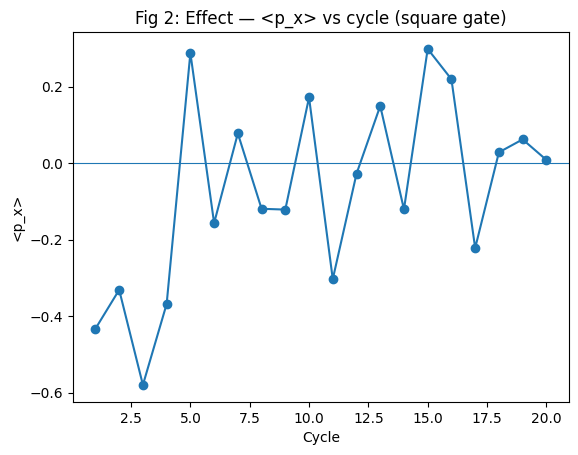

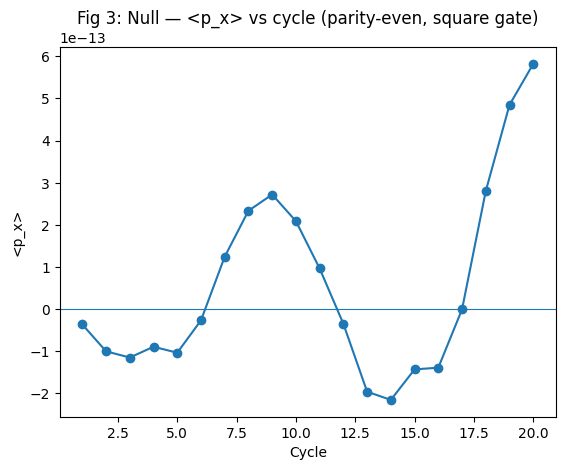

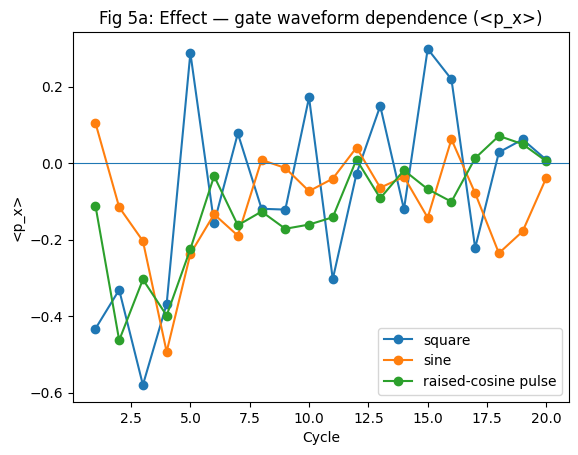

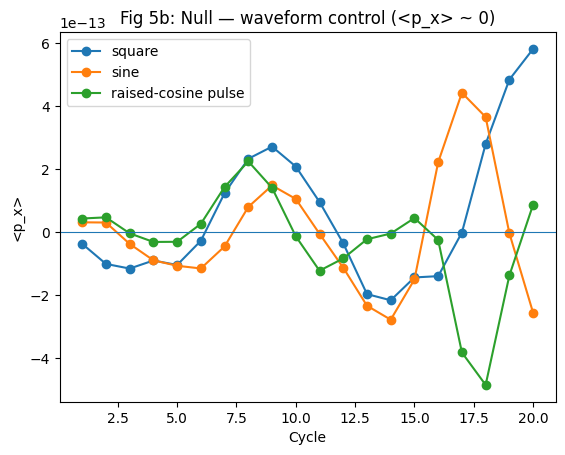

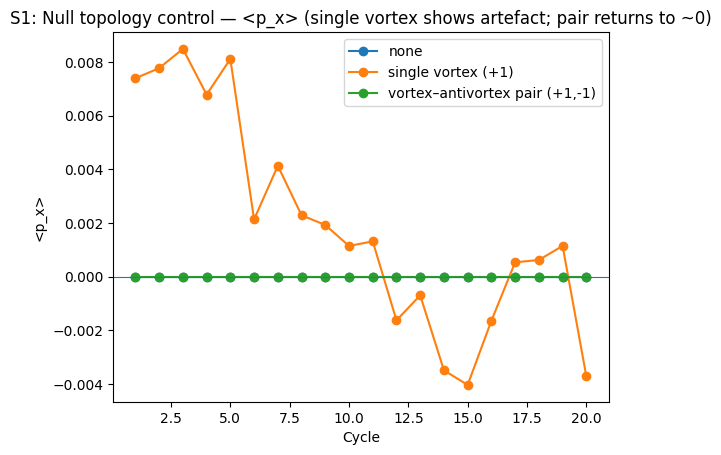

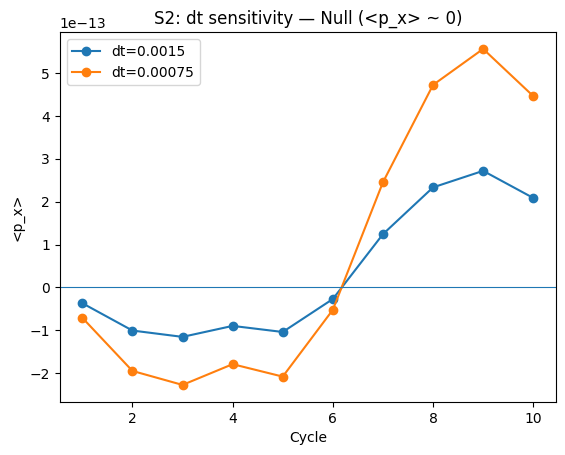

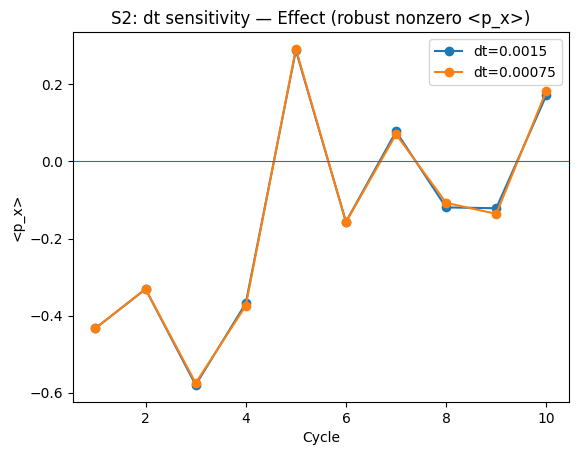

In [ ]:
import os, json
import numpy as np
import matplotlib.pyplot as plt

RUN_DIR = "/content/gqr_gearing_runs"  # change to Drive dir if you like
TAG = None  # set to your tag string if multiple batches exist

def load_npz_by_prefix(prefix, tag=None, run_dir=RUN_DIR):
    files = [f for f in os.listdir(run_dir) if f.startswith(prefix) and f.endswith(".npz")]
    if tag is not None:
        files = [f for f in files if f"_{tag}.npz" in f]
    if not files:
        raise FileNotFoundError(f"No npz found for prefix={prefix} tag={tag} in {run_dir}")
    # If multiple, pick newest
    files.sort(key=lambda f: os.path.getmtime(os.path.join(run_dir, f)), reverse=True)
    path = os.path.join(run_dir, files[0])
    z = np.load(path, allow_pickle=True)
    cfg = json.loads(str(z["cfg_json"]))
    rec = z["records"]
    return cfg, rec, path

def plot_px(prefixes, labels, title):
    plt.figure()
    for pref, lab in zip(prefixes, labels):
        _, rec, _ = load_npz_by_prefix(pref, tag=TAG)
        plt.plot(rec["cycle"], rec["px_mean"], marker="o", label=lab)
    plt.axhline(0, lw=0.8)
    plt.xlabel("Cycle")
    plt.ylabel("<p_x>")
    plt.title(title)
    plt.legend()
    plt.show()

def plot_null_scale(prefix, title):
    _, rec, _ = load_npz_by_prefix(prefix, tag=TAG)
    plt.figure()
    plt.plot(rec["cycle"], rec["px_mean"], marker="o")
    plt.axhline(0, lw=0.8)
    plt.xlabel("Cycle")
    plt.ylabel("<p_x>")
    plt.title(title)
    plt.show()

# -------- Figure 2: effect (square) --------
plot_null_scale("fig2_effect_square", "Fig 2: Effect — <p_x> vs cycle (square gate)")

# -------- Figure 3: parity-even null (square) --------
plot_null_scale("fig3_null_square", "Fig 3: Null — <p_x> vs cycle (parity-even, square gate)")

# -------- Figure 5a: waveform dependence (effect) --------
plot_px(
    ["fig5a_effect_square", "fig5a_effect_sine", "fig5a_effect_rcos"],
    ["square", "sine", "raised-cosine pulse"],
    "Fig 5a: Effect — gate waveform dependence (<p_x>)"
)

# -------- Figure 5b: waveform null control --------
plot_px(
    ["fig5b_null_square", "fig5b_null_sine", "fig5b_null_rcos"],
    ["square", "sine", "raised-cosine pulse"],
    "Fig 5b: Null — waveform control (<p_x> ~ 0)"
)

# -------- SI S1: strict topology control in the null --------
plot_px(
    ["S1_null_topo_none", "S1_null_topo_single", "S1_null_topo_pair"],
    ["none", "single vortex (+1)", "vortex–antivortex pair (+1,-1)"],
    "S1: Null topology control — <p_x> (single vortex shows artefact; pair returns to ~0)"
)

# -------- SI S2: dt sensitivity (null + effect) --------
plot_px(
    ["S2_null_dt_0.0015", "S2_null_dt_0.00075"],
    ["dt=0.0015", "dt=0.00075"],
    "S2: dt sensitivity — Null (<p_x> ~ 0)"
)
plot_px(
    ["S2_effect_dt_0.0015", "S2_effect_dt_0.00075"],
    ["dt=0.0015", "dt=0.00075"],
    "S2: dt sensitivity — Effect (robust nonzero <p_x>)"
)

In [ ]:
import os
import zipfile

# 1) See what folders actually exist
print("Contents of /content:")
print(os.listdir("/content"))

# 2) SET THIS to the folder you want to zip
FOLDER = "/content/gqr_gearing_runs"   # change if name differs
ZIP_PATH = FOLDER + ".zip"

# 3) Zip it
with zipfile.ZipFile(ZIP_PATH, "w", zipfile.ZIP_DEFLATED) as zf:
    for root, dirs, files in os.walk(FOLDER):
        for file in files:
            full_path = os.path.join(root, file)
            rel_path = os.path.relpath(full_path, FOLDER)
            zf.write(full_path, rel_path)

print("Zipped to:", ZIP_PATH)
print("Now in /content:", os.listdir("/content"))

Contents of /content:
['.config', 'drive', 'gqr_gearing_runs.zip', 'gqr_gearing_runs', 'sample_data']
Zipped to: /content/gqr_gearing_runs.zip
Now in /content: ['.config', 'drive', 'gqr_gearing_runs.zip', 'gqr_gearing_runs', 'sample_data']
